# Static potential:circuit and hamiltonian

In [20]:
import qiskit

In [21]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations
import primme

In [22]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz


In [23]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf

##### Class Hamilt

In [73]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli=False
#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

static_charges_values_input = latt.distances_coord
print(static_charges_values_input,latt.r_list,set(latt.r_list))

#static charge
qstat=static_charges_values_input[-1]

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (0, 2): 1} {(0, 0): -1, (1, 0): 1}
 {(0, 0): -1, (1, 1): 1} {(0, 0): -1, (1, 2): 1} {(0, 0): -1, (2, 0): 1}
 {(0, 0): -1, (2, 1): 1} {(0, 0): -1, (2, 2): 1}] [1.0 2.0 1.0 1.4142135623730951 2.23606797749979 2.0 2.23606797749979
 2.8284271247461903] {1.0, 2.0, 2.23606797749979, 2.8284271247461903, 1.4142135623730951}


In [74]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.012379169464111328 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 3.2194390296936035 seconds
>> Suppression term built.  Execution time: 0.0025053024291992188 seconds


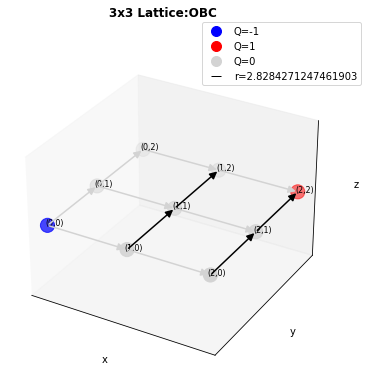

In [75]:
latt.draw_graph_func(gauss_law_fig=True,static_charges=qstat,e_op_free=class_H_oprt.e_op_free) 

In [76]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

#### Circuit

Total n.er of CNOT gates (Toffoli are decomposed): 176
Total n.er of parameters: 32


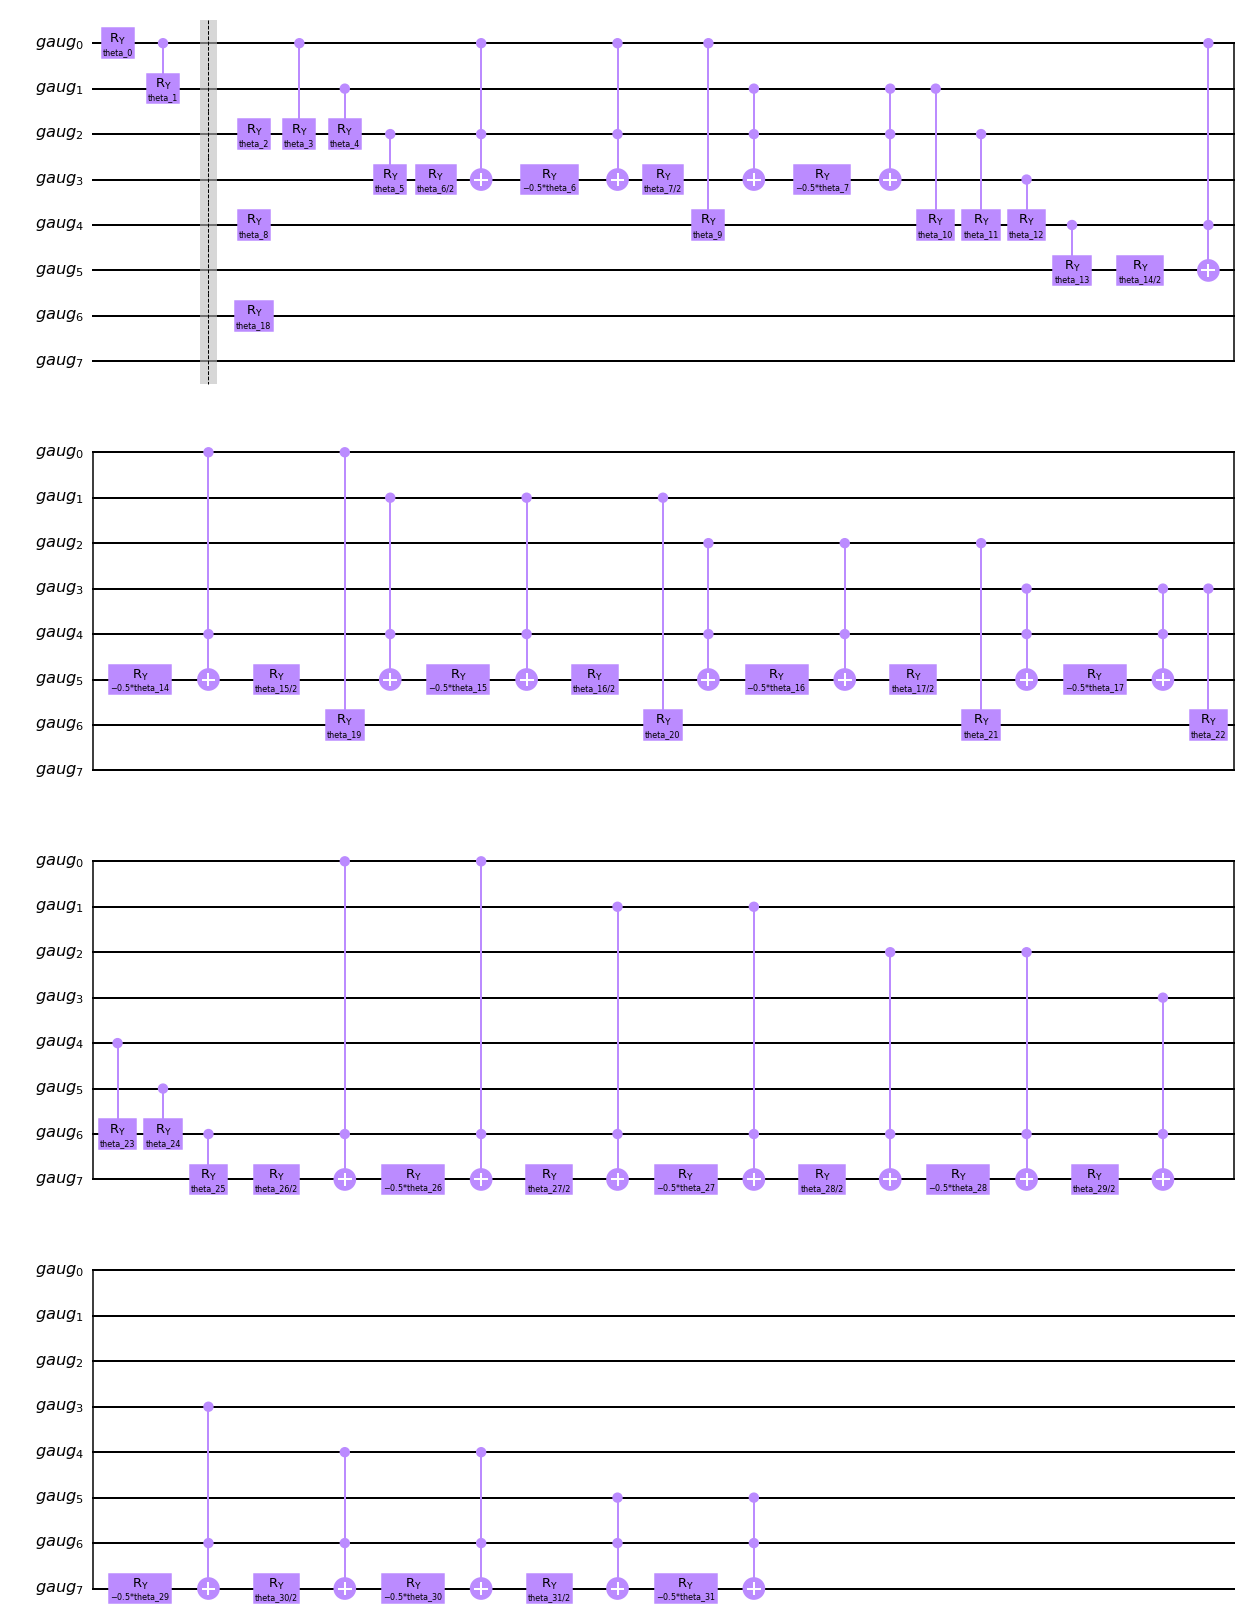

In [28]:
nlayers= 1
entanglement='full'
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qc_tot2 = ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=False,nlayers=nlayers)[0]

print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl')

### Results

In [34]:
ls

README.md                            results_rndpoint.txt
quantinuum_staticcharges_test.ipynb  results_vacpoint.txt


In [62]:
def read_datafile(filetxt):
    import re

    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_ed = r'E_0\(ED\)= (-?\d+\.\d+)'
    pattern_vqd = r'E_0\(VQD\)= (-?\d+\.\d+)'
    pattern_std_dev = r'std\. dev\. (-?\d+\.\d+)'
    pattern_params = r'final parameters: ({.*?})'
    pattern_fidelity = r'E_0: (\d+\.\d+)'

    ed_values = []
    vqd_values = []
    std_dev_values = []
    param_values = []
    fidelity_values = []

    with open(filename, 'r') as file:
        data = file.read()

        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqd_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract final parameters as dictionaries
        param_matches = re.findall(pattern_params, data)
        #param_values = [eval(param_match) for param_match in param_matches]
        param_values = [param_match for param_match in param_matches]
        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

    return ed_values, vqd_values, std_dev_values,fidelity_values, param_values


In [63]:
E_0_ED,E_0_VQD,stddev_VQD,fid_VQD,param_VQD= read_datafile('results_vacpoint.txt')
E_0_ED,E_0_VQD_rnd,stddev_VQD_rnd,fid_VQD_rnd,param_VQD_rnd= read_datafile('results_rndpoint.txt')

In [64]:

E_0_ED = np.array(E_0_ED)[np.argsort(latt.r_list)]
E_0_VQD = np.array(E_0_VQD)[np.argsort(latt.r_list)]
stddev_VQD = np.array(stddev_VQD)[np.argsort(latt.r_list)]
E_0_VQD_rnd = np.array(E_0_VQD_rnd)[np.argsort(latt.r_list)]
stddev_VQD_rnd = np.array(stddev_VQD_rnd)[np.argsort(latt.r_list)]
latt_rlist_ordered = np.array(latt.r_list)[np.argsort(latt.r_list)].astype(float)

In [65]:
#fitting
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b

def func_log(x, a, b,c):
    return a * np.log(x) + b*x + c


fit l=1 y=0.4431310615871735x-0.8601753643050346


Text(0.5, 1.0, '3x3mbasisFalse puregaugeTrue g1 pbcFalse l1')

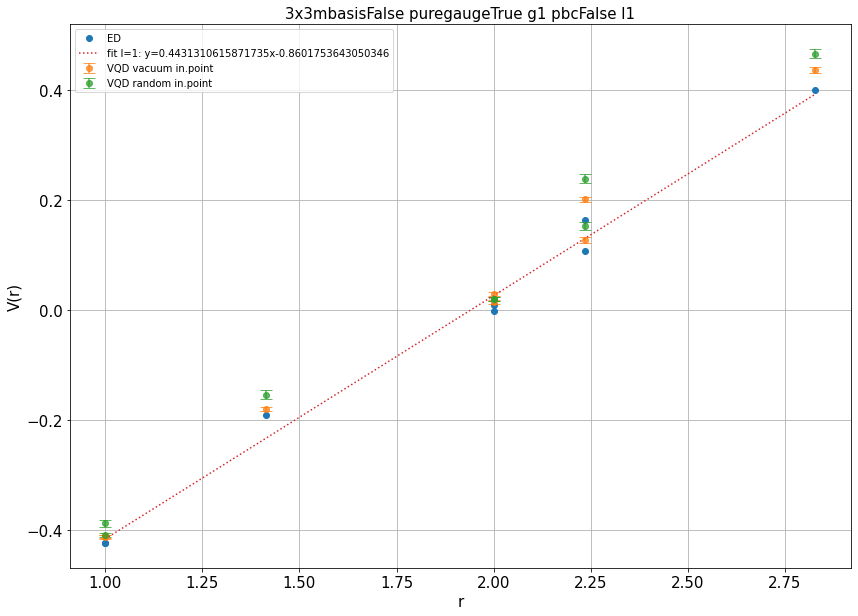

In [110]:
#
plt.figure(figsize=(14,10))
plt.plot(latt_rlist_ordered,E_0_ED,'o',label=f'ED')
plt.errorbar(latt_rlist_ordered, E_0_VQD, yerr=stddev_VQD,label=r"VQD vacuum in.point",alpha=.75, fmt='o', capsize=6, capthick=1)
plt.errorbar(latt_rlist_ordered,E_0_VQD_rnd, yerr=stddev_VQD_rnd, label=r"VQD random in.point",alpha=.75, fmt='o', capsize=6, capthick=1)

# popt, pcov = curve_fit(func_log, latt_rlist_ordered, E_0_ED)
# plt.plot(latt_rlist_ordered, func_log(latt_rlist_ordered, *popt), label=f'fit log l={l}: y={popt[0]}log(x)+{popt[1]}x+{popt[2]}',linestyle='dotted')
# print(f'fit log l={l} y={popt[0]}log(x)+{popt[1]}x+{popt[2]}')

popt, pcov = curve_fit(func, latt_rlist_ordered, E_0_ED)
plt.plot(latt_rlist_ordered, func(latt_rlist_ordered, *popt), label=f'fit l={l}: y={popt[0]}x{popt[1]}',linestyle='dotted')
print(f'fit l={l} y={popt[0]}x{popt[1]}')

#plt.ylim(-0.45,0.20)
plt.xlabel('r',size=15)
plt.ylabel('V(r)',size=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.legend()
plt.title('x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}',size=15)

Text(0.5, 0.98, '3x3mbasisFalse puregaugeTrue g1 pbcFalse l1')

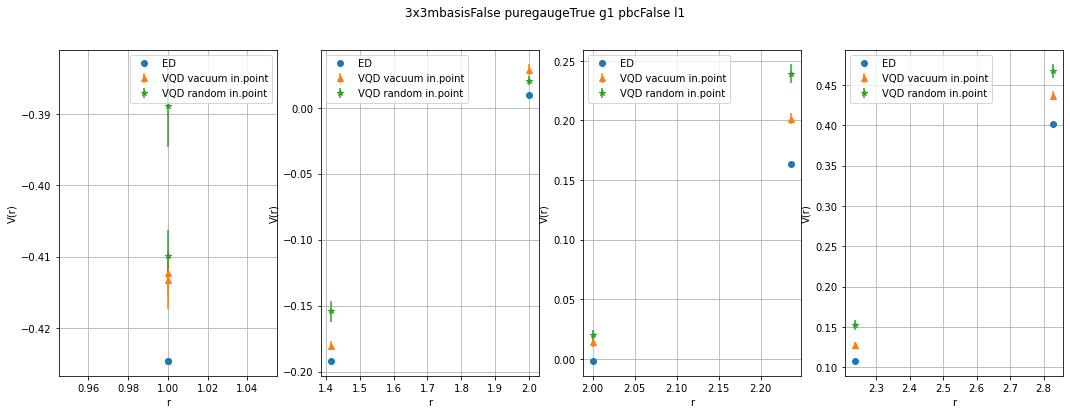

In [105]:
fig,ax = plt.subplots(1,4, figsize=(18, 6))

for n in range(4):
    ax[n].plot(latt_rlist_ordered[2*n:2*n+2],E_0_ED[2*n:2*n+2],'o',label=f'ED')
    ax[n].errorbar(latt_rlist_ordered[2*n:2*n+2], E_0_VQD[2*n:2*n+2], yerr=stddev_VQD[2*n:2*n+2], fmt='^',label=r"VQD vacuum in.point")
    ax[n].errorbar(latt_rlist_ordered[2*n:2*n+2],E_0_VQD_rnd[2*n:2*n+2], yerr=stddev_VQD_rnd[2*n:2*n+2], fmt='*',label=r"VQD random in.point")
    
    ax[n].grid()
    ax[n].legend()
    ax[n].set_xlabel('r')
    ax[n].set_ylabel('V(r)')

fig.suptitle('x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}')

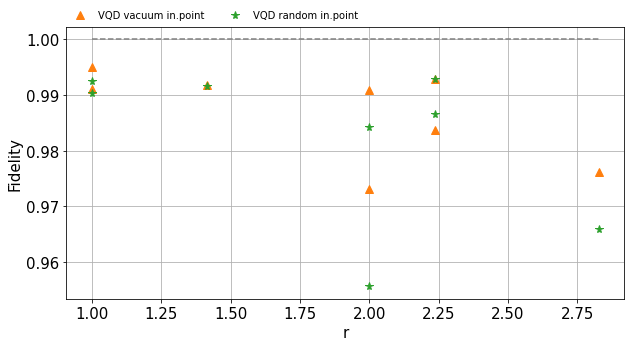

In [107]:
plt.figure(figsize=(10,5))
plt.hlines(1,latt_rlist_ordered[0],latt_rlist_ordered[-1],linestyles='dashed',colors='gray')
plt.plot(latt_rlist_ordered,fid_VQD,'^',label='VQD vacuum in.point',color='C1',markersize=8)
plt.plot(latt_rlist_ordered,fid_VQD_rnd,'*',label='VQD random in.point',color='C2',markersize=8)
plt.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01),ncol=2, borderaxespad=0, frameon=False)
plt.xlabel('r',size=15)
plt.ylabel('Fidelity',size=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()